# Best Model (NGBoost) menggunakan Hyperparameter Tuning
Penelitian "PENERAPAN MACHINE LEARNING UNTUK ESTIMASI REMAINING USEFUL LIFE (RUL) ROLLER PADA TOP WEIGHTING ARM MESIN RING SPINNING (STUDI KASUS PT. XYZ)" - Hanindita Jati (2025)

In [1]:
# Import Libraries
import warnings
warnings.filterwarnings('ignore')
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from ngboost import NGBRegressor
from ngboost.distns import Normal
from sklearn.metrics import *
from sklearn.base import clone

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

Baca data tanpa feature processing

In [2]:
# Baca Data
data = pd.read_excel('DATAMODEL_2_clean.xlsx', sheet_name='Sheet1') # pake data yg ada outlier jelas di excel
#data = data.drop(columns=['ipi', 'ap']) # kolom rsf (udah bener tapi masi v1) dan ap belum bener, jadi diabaikan dulu
print(f'data.shape : {data.shape}\n')
print(data.info())
data.head(2)

data.shape : (23700, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23700 entries, 0 to 23699
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    23700 non-null  datetime64[ns]
 1   RSF     23700 non-null  object        
 2   ne      23700 non-null  int64         
 3   u       23700 non-null  float64       
 4   cvm     23700 non-null  float64       
 5   cv1m    23700 non-null  float64       
 6   thin    23700 non-null  int64         
 7   thick   23700 non-null  int64         
 8   neps    23700 non-null  int64         
 9   ha      23700 non-null  float64       
 10  D1      23700 non-null  float64       
 11  D2      23700 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(4), object(1)
memory usage: 2.2+ MB
None


,Date,RSF,ne,u,cvm,cv1m,thin,thick,neps,ha,D1,D2
0,2024-02-01,1C,28,8.820,11.090,3.310,0,2,2,3.870,30.000,28.500
1,2024-02-02,1C,28,8.826,11.096,3.337,0,2,2,3.869,29.992,28.496


## Pola Degradasi Roller

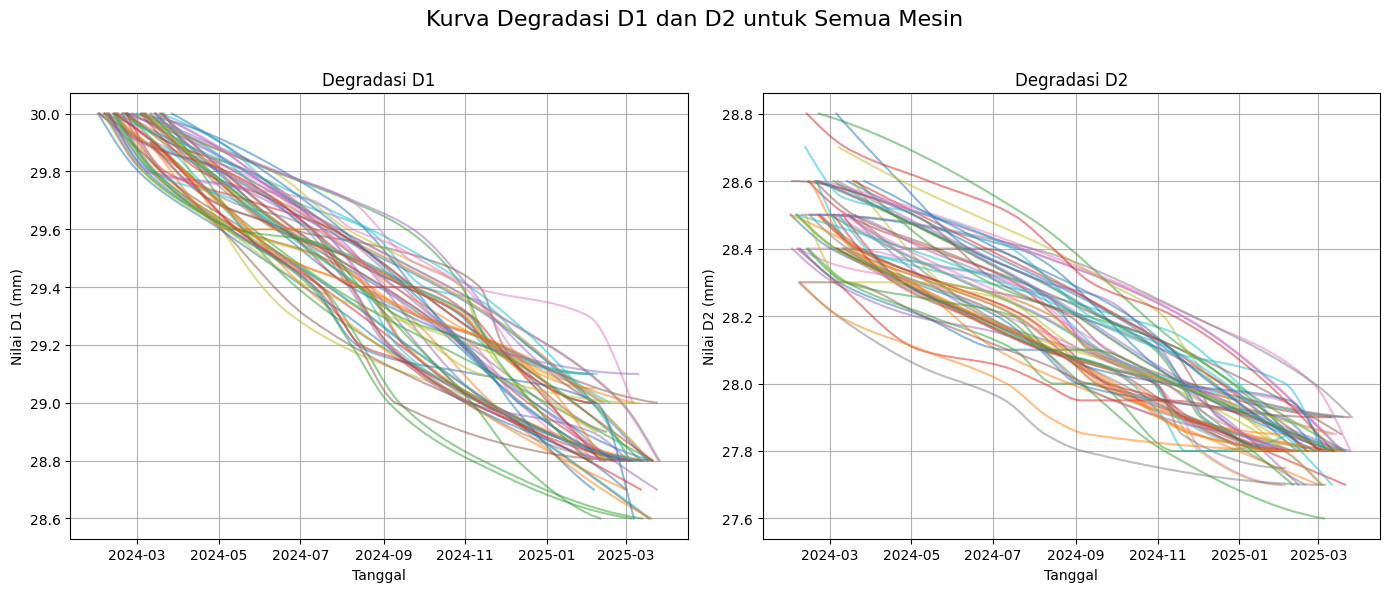

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

for key, group in data.groupby('RSF'):
    axs[0].plot(group['Date'], group['D1'], alpha=0.5)
axs[0].set_title('Degradasi D1')
axs[0].set_xlabel('Tanggal')
axs[0].set_ylabel('Nilai D1 (mm)')
axs[0].grid(True)

for key, group in data.groupby('RSF'):
    axs[1].plot(group['Date'], group['D2'], alpha=0.5)
axs[1].set_title('Degradasi D2')
axs[1].set_xlabel('Tanggal')
axs[1].set_ylabel('Nilai D2 (mm)')
axs[1].grid(True)

# Judul keseluruhan
fig.suptitle('Kurva Degradasi D1 dan D2 untuk Semua Mesin', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Menambah kolom elapsed_days
Untuk mengetahui berapa hari berlalu sejak hari pertama tiap mesin (RSF)

In [4]:
data['elapsed_days'] = data.groupby('RSF')['Date'].transform(lambda x: (x - x.min()).dt.days)

data

,Date,RSF,ne,u,cvm,cv1m,thin,thick,neps,ha,D1,D2,elapsed_days
0,2024-02-01,1C,28,8.820,11.090,3.310,0,2,2,3.870,30.000,28.500,0
1,2024-02-02,1C,28,8.826,11.096,3.337,0,2,2,3.869,29.992,28.496,1
2,2024-02-03,1C,28,8.832,11.101,3.364,0,2,2,3.868,29.984,28.492,2
3,2024-02-04,1C,28,8.838,11.107,3.392,0,2,2,3.867,29.977,28.488,3
4,2024-02-05,1C,28,8.843,11.113,3.419,0,2,2,3.866,29.969,28.485,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23695,2025-02-22,9A,40,10.891,13.736,3.826,2,10,23,4.119,28.806,27.809,332
23696,2025-02-23,9A,40,10.896,13.742,3.834,2,10,23,4.129,28.804,27.807,333
23697,2025-02-24,9A,40,10.901,13.748,3.843,2,10,23,4.139,28.803,27.804,334
23698,2025-02-25,9A,40,10.905,13.754,3.851,2,10,24,4.149,28.801,27.802,335


## Hyperparameter Tuning Model NGBoost

- Dilakukan dengan tujuan untuk menemukan kombinasi parameter terbaik untuk meningkatkan akurasi dan generalisasi model (Bergstra & Bengio, 2012).

- Bergstra, J., & Bengio, Y. (2012). Random search for hyper-parameter optimization. The journal of machine learning research, 13(1), 281-305. DOI: 10.5555/2188385.2188395

### Metode RandomizedSearchCV

- n_iter=20 : mencoba 20 kombinasi parameter secara acak.
- cv=3 : melakukan 3-fold cross-validation.
- scoring='neg_mean_absolute_error' : metrik evaluasi menggunakan MAE.
- RandomizedSearchCV dinilai lebih efisien dari GridSearch pada ruang parameter besar (Bergstra & Bengio, 2012).
- Meningkatkan akurasi prediksi mean dan distribusi.
- Mengurangi risiko overfitting/underfitting.
- Efisien dalam waktu komputasi.

- Bergstra, J., & Bengio, Y. (2012). Random search for hyper-parameter optimization. The journal of machine learning research, 13(1), 281-305. DOI: 10.5555/2188385.2188395

In [5]:
target_cols = ['D1', 'D2']

X_full = data.drop(columns=target_cols)  # Tetap simpan RSF dan elapsed_days
y = data[target_cols]

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)

numerical_features = data.select_dtypes(include='number').columns.tolist()
exclude_cols = ['D1', 'D2']
features = [col for col in numerical_features if col not in exclude_cols]

X_train = X_train_raw[features]
X_test = X_test_raw[features]

param_dist = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.1),
    'minibatch_frac': uniform(0.5, 0.5),
    'col_sample': uniform(0.5, 0.5),
    'natural_gradient': [True, False]
}

ngb_d1 = NGBRegressor(Dist=Normal, verbose=False)
ngb_d2 = NGBRegressor(Dist=Normal, verbose=False)

search_d1 = RandomizedSearchCV(
    estimator=ngb_d1,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    verbose=1,
    n_jobs=-1,
    scoring='neg_mean_absolute_error'
)
search_d1.fit(X_train, y_train['D1'])

search_d2 = RandomizedSearchCV(
    estimator=ngb_d2,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    verbose=1,
    n_jobs=-1,
    scoring='neg_mean_absolute_error'
)
search_d2.fit(X_train, y_train['D2'])

best_ngb_d1 = search_d1.best_estimator_
best_ngb_d2 = search_d2.best_estimator_

print("Best Params D1:", search_d1.best_params_)
print("Best Params D2:", search_d2.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Params D1: {'col_sample': np.float64(0.8239822694928498), 'learning_rate': np.float64(0.06142085887397655), 'minibatch_frac': np.float64(0.9671489308194068), 'n_estimators': 418, 'natural_gradient': False}
Best Params D2: {'col_sample': np.float64(0.8597648280865648), 'learning_rate': np.float64(0.05632054968793451), 'minibatch_frac': np.float64(0.6309792597550803), 'n_estimators': 493, 'natural_gradient': False}


## Metrik Evaluasi Model

Metrik evaluasi model regresi yang digunakan adalah:


#### 1. Root Mean Squared Error (RMSE)

$$
\text{RMSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 }
$$

#### 2. Mean Absolute Error (MAE)

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
$$

#### 3. Mean Absolute Percentage Error (MAPE)

$$
\text{MAPE} = \frac{100\%}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|
$$

#### 4. Coefficient of Determination (R² Score)

$$
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
$$

Keterangan:

$$
\begin{align*}
y_i &= \text{nilai aktual ke-}i \\
\hat{y}_i &= \text{nilai prediksi ke-}i \\
\bar{y} &= \text{rata-rata dari seluruh } y_i \\
n &= \text{jumlah sampel}
\end{align*}
$$


In [6]:
# Evaluasi model
y_pred_d1 = best_ngb_d1.predict(X_test)
y_pred_d2 = best_ngb_d2.predict(X_test)

y_true_d1 = y_test['D1'].values
y_true_d2 = y_test['D2'].values

# D1
rmse_d1 = np.sqrt(mean_squared_error(y_true_d1, y_pred_d1))
mae_d1 = mean_absolute_error(y_true_d1, y_pred_d1)
mape_d1 = mean_absolute_percentage_error(y_true_d1, y_pred_d1)
r2_d1 = r2_score(y_true_d1, y_pred_d1)

# D2
rmse_d2 = np.sqrt(mean_squared_error(y_true_d2, y_pred_d2))
mae_d2 = mean_absolute_error(y_true_d2, y_pred_d2)
mape_d2 = mean_absolute_percentage_error(y_true_d2, y_pred_d2)
r2_d2 = r2_score(y_true_d2, y_pred_d2)

# Cetak hasil
print("RMSE untuk D1 dan D2:", [rmse_d1, rmse_d2])
print("MAE untuk D1 dan D2:", [mae_d1, mae_d2])
print("MAPE untuk D1 dan D2:", [mape_d1, mape_d2])
print("R2 score untuk D1 dan D2:", [r2_d1, r2_d2])

RMSE untuk D1 dan D2: [np.float64(0.05271699383623312), np.float64(0.03691963253910584)]
MAE untuk D1 dan D2: [0.03482422558991878, 0.02458220856046965]
MAPE untuk D1 dan D2: [0.001187043740374103, 0.0008724623574598366]
R2 score untuk D1 dan D2: [0.9777894157860412, 0.974557525702335]


Interpretasi:

- RMSE & MAE rendah: Menunjukkan error pada prediksi sangat kecil. Untuk skala diameter (sekitar 28–30 mm), kesalahan <0.1 mm masih dalam toleransi proses QC industri tekstil (biasanya ±0.2 mm).

- MAPE < 1%: Tergolong bagus, menunjukkan model presisi dalam memprediksi. Umumnya, MAPE < 10% dianggap baik dalam konteks prediksi industri (Hyndman & Koehler, 2006).

- R² mendekati 1: Artinya >97% (D1) dan >97% (D2) variasi dalam data berhasil dijelaskan oleh model (Chicco dkk., 2021).

Penggunaan hyperparameter tuning berpengaruh positif terhadap performa model. Dibuktikan dari peningkatan semua metrik evaluasi jika dibandingkan dengan **baseline model NGBoost**

dari

- RMSE     (baseline model): [0.091, 0.076]
- MAE      (baseline model): [0.063, 0.061]
- MAPE     (baseline model): [0.002, 0.002]
- R2 score (baseline model): [0.958, 0.924]

menjadi

- RMSE     (best model): [0.052, 0.036]
- MAE      (best model): [0.034, 0.024]
- MAPE     (best model): [0.001, 0.001]
- R2 score (best model): [0.977, 0.974]

Referensi:

- Hyndman, R. J., & Koehler, A. B. (2006). Another look at measures of forecast accuracy. International Journal of Forecasting, 22(4), 679–688. https://doi.org/10.1016/j.ijforecast.2006.03.001

- Chicco, D., Warrens, M. J., & Jurman, G. (2021). The coefficient of determination R-squared is more informative than SMAPE, MAE, MAPE, MSE and RMSE in regression analysis evaluation. PeerJ Computer Science, 7, 1–24. https://doi.org/10.7717/PEERJ-CS.623

## Cross Validation

Cross-Validation (CV) diperlukan untuk mengukur kemampuan generalisasi model ke data baru yang tidak pernah dilihat saat pelatihan dengan membagi data menjadi beberapa fold (Koul, Becchio, & Cavallo, 2018)

CV dapat mengurangi risiko overfitting dan underfitting (Koul et al, 2018).

Fold yang digunakan pada CV sebanyak 5-fold, agar dapat memberikan estimasi performa yang akurat dengan beban komputasi yang rendah (López, Fernández, García, Palade, & Herrera, 2013).


Referensi:
- Koul, A., Becchio, C., & Cavallo, A. (2018). Cross-validation approaches for replicability in psychology. Frontiers in Psychology, 9, 1117.
https://doi.org/10.3389/fpsyg.2018.01117
- López, V., Fernández, A., García, S., Palade, V., & Herrera, F. (2013). An insight into classification with imbalanced data: Empirical results and current trends on using data intrinsic characteristics. Information Sciences, 250, 113–141.
https://doi.org/10.1016/j.ins.2013.07.007

In [7]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores, mae_scores, mape_scores, r2_scores = [], [], [], []

for train_idx, val_idx in kf.split(X_full):
    X_train_fold = X_full.iloc[train_idx][features]
    X_val_fold = X_full.iloc[val_idx][features]
    
    y_train_d1_fold = y.iloc[train_idx]['D1']
    y_val_d1_fold = y.iloc[val_idx]['D1']
    y_train_d2_fold = y.iloc[train_idx]['D2']
    y_val_d2_fold = y.iloc[val_idx]['D2']
    
    cv_ngb_d1 = clone(best_ngb_d1)
    cv_ngb_d2 = clone(best_ngb_d2)

    cv_ngb_d1.fit(X_train_fold, y_train_d1_fold)
    cv_ngb_d2.fit(X_train_fold, y_train_d2_fold)

    y_pred_d1_fold = cv_ngb_d1.predict(X_val_fold)
    y_pred_d2_fold = cv_ngb_d2.predict(X_val_fold)

    rmse = [np.sqrt(mean_squared_error(y_val_d1_fold, y_pred_d1_fold)),
            np.sqrt(mean_squared_error(y_val_d2_fold, y_pred_d2_fold))]
    
    mae = [mean_absolute_error(y_val_d1_fold, y_pred_d1_fold),
           mean_absolute_error(y_val_d2_fold, y_pred_d2_fold)]

    mape = [mean_absolute_percentage_error(y_val_d1_fold, y_pred_d1_fold),
            mean_absolute_percentage_error(y_val_d2_fold, y_pred_d2_fold)]

    r2 = [r2_score(y_val_d1_fold, y_pred_d1_fold),
          r2_score(y_val_d2_fold, y_pred_d2_fold)]

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    mape_scores.append(mape)
    r2_scores.append(r2)

In [8]:
rmse_scores = np.array(rmse_scores)
mae_scores = np.array(mae_scores)
mape_scores = np.array(mape_scores)
r2_scores = np.array(r2_scores)

# Tampilkan hasil
metrics = {'RMSE': rmse_scores, 'MAE': mae_scores, 'MAPE': mape_scores, 'R2': r2_scores}
target_names = ['D1', 'D2']

for i, target in enumerate(target_names):
    print(f"\n=== Cross-Validation {target} ===")
    for metric_name, scores in metrics.items():
        values = scores[:, i]
        average = np.mean(values)
        formatted_values = " ".join([f"{v:.8f}" for v in values])
        print(f"{metric_name} Scores: [{formatted_values}]")
        print(f"Average {metric_name}: {average:.4f}")


=== Cross-Validation D1 ===
RMSE Scores: [0.05279794 0.05237338 0.05338221 0.05199750 0.05222779]
Average RMSE: 0.0526
MAE Scores: [0.03509618 0.03516547 0.03567187 0.03476564 0.03538141]
Average MAE: 0.0352
MAPE Scores: [0.00119606 0.00119880 0.00121686 0.00118538 0.00120599]
Average MAPE: 0.0012
R2 Scores: [0.97772116 0.97818876 0.97748894 0.97876477 0.97851283]
Average R2: 0.9781

=== Cross-Validation D2 ===
RMSE Scores: [0.03698512 0.03566835 0.03672623 0.03715323 0.03616036]
Average RMSE: 0.0365
MAE Scores: [0.02435351 0.02390506 0.02448630 0.02477155 0.02418075]
Average MAE: 0.0243
MAPE Scores: [0.00086424 0.00084819 0.00086878 0.00087893 0.00085781]
Average MAPE: 0.0009
R2 Scores: [0.97446719 0.97593602 0.97490904 0.97458340 0.97592944]
Average R2: 0.9752


Interpretasi:
- Model Baseline NGBoost dengan multi-output mampu memprediksi degradasi roller (D1, D2) secara akurat dan stabil.
- CV memperlihatkan performa konsisten antar fold, yang berarti bahwa model dapat diandalkan pada data baru.

## Hasil Prediksi banding Aktual

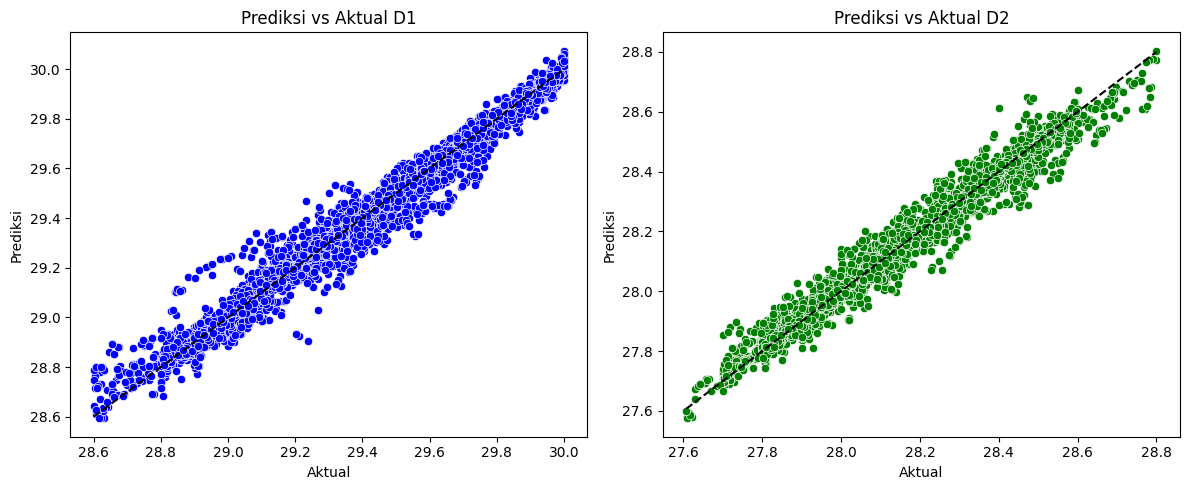

In [9]:
y_true_d1 = y_test['D1'].to_numpy()
y_true_d2 = y_test['D2'].to_numpy()
y_pred_d1 = y_pred_d1
y_pred_d2 = y_pred_d2

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# D1
sns.scatterplot(x=y_true_d1, y=y_pred_d1, ax=axes[0], color='blue')
axes[0].plot([y_true_d1.min(), y_true_d1.max()],
             [y_true_d1.min(), y_true_d1.max()], 'k--')
axes[0].set_title('Prediksi vs Aktual D1')
axes[0].set_xlabel('Aktual')
axes[0].set_ylabel('Prediksi')

# D2
sns.scatterplot(x=y_true_d2, y=y_pred_d2, ax=axes[1], color='green')
axes[1].plot([y_true_d2.min(), y_true_d2.max()],
             [y_true_d2.min(), y_true_d2.max()], 'k--')
axes[1].set_title('Prediksi vs Aktual D2')
axes[1].set_xlabel('Aktual')
axes[1].set_ylabel('Prediksi')

plt.tight_layout()
plt.show()

Interpretasi:

- Kedua grafik menunjukkan bahwa model regresi yang digunakan dapat memprediksi D1 dan D2 dengan baik.

- Distribusi titik yang mendekati garis diagonal menunjukkan bahwa tidak terdapat pola kesalahan yang konsisten. Hal ini menandakan model tidak bias.

- Performa model untuk D1 dan D2 sama baiknya, keduanya berada pada tingkat akurasi tinggi (R² > 0.9).

- Visualisasi ini bersama dengan hasil metrik evaluasi menunjukkan bahwa **model NGBoost** telah berhasil melakukan prediksi dengan presisi tinggi untuk kedua target (D1 dan D2), serta tidak menunjukkan adanya pola kesalahan sistematis.

Hyndman, R. J., & Koehler, A. B. (2006). Another look at measures of forecast accuracy. International Journal of Forecasting, 22(4), 679–688. https://doi.org/10.1016/j.ijforecast.2006.03.001

## Residual Plot

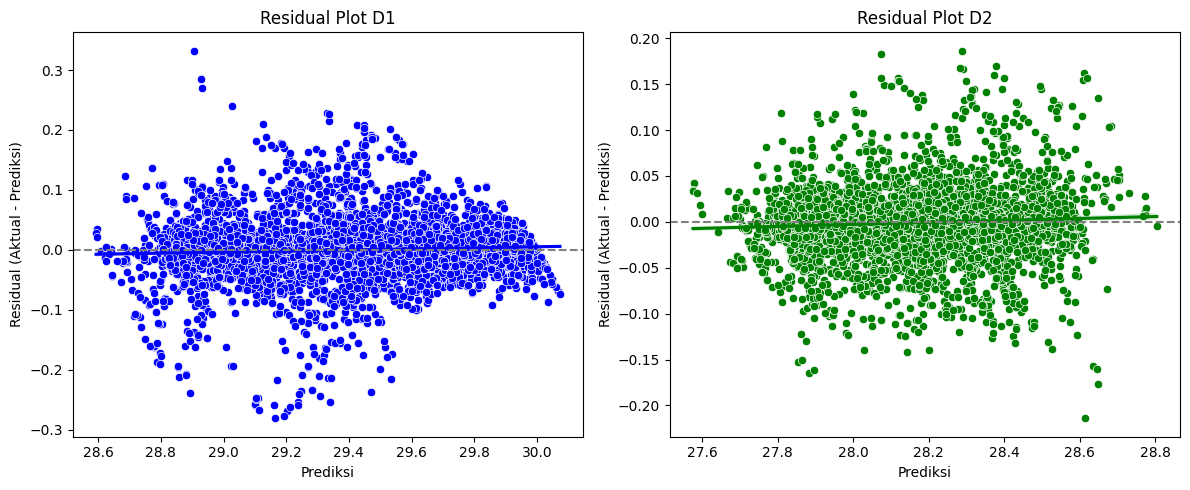

In [10]:
residuals_d1 = y_true_d1 - y_pred_d1
residuals_d2 = y_true_d2 - y_pred_d2

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Residual D1
sns.scatterplot(x=y_pred_d1, y=residuals_d1, ax=axes[0], color='blue')
sns.regplot(x=y_pred_d1, y=residuals_d1, ax=axes[0], scatter=False, color='blue')
axes[0].axhline(0, linestyle='--', color='gray')
axes[0].set_title('Residual Plot D1')
axes[0].set_xlabel('Prediksi')
axes[0].set_ylabel('Residual (Aktual - Prediksi)')

# Residual D2
sns.scatterplot(x=y_pred_d2, y=residuals_d2, ax=axes[1], color='green')
sns.regplot(x=y_pred_d2, y=residuals_d2, ax=axes[1], scatter=False, color='green')
axes[1].axhline(0, linestyle='--', color='gray')
axes[1].set_title('Residual Plot D2')
axes[1].set_xlabel('Prediksi')
axes[1].set_ylabel('Residual (Aktual - Prediksi)')

plt.tight_layout()
plt.show()

Berdasarkan plot prediksi vs aktual dan residual untuk D1 dan D2, model prediksi menunjukkan performa yang cukup baik. Nilai prediksi mengikuti pola linier terhadap nilai aktual dengan persebaran yang cukup rapat pada sepanjang garis diagonal, yang menandakan model memiliki akurasi prediksi yang tinggi. Residual plot menunjukkan penyebaran error yang acak dan simetris di sekitar garis nol, tanpa pola sistematis yang jelas. Hal ini mengindikasikan bahwa model memenuhi asumsi linearitas dan homoskedastisitas, serta tidak terdapat indikasi kuat adanya outlier ekstrem yang mengganggu.

Dengan tidak ditemukannya pola berbentuk kurva atau penyebaran residual yang melebar atau mengerucut, dapat dikatakan bahwa model regresi yang digunakan tidak menunjukkan bias signifikan dan cukup stabil untuk digunakan sebagai alat prediktif pada data ini.

Temuan ini konsisten dengan kriteria evaluasi model regresi linier yang baik, di mana penyebaran residual yang acak dan tanpa pola merupakan indikator bahwa model telah menangkap pola relasi antar variabel dengan cukup tepat (James et al., 2021).

- James, G., Witten, D., Hastie, T., & Tibshirani, R. (2021). An Introduction to Statistical Learning: with Applications in R (2nd ed.). Springer. https://doi.org/10.1007/978-1-0716-1418-1

## Metrik Evaluasi Prognostik

Metrik evaluasi prognostik yang digunakan (Saxena et al, 2010):
1. Prognostic Horizon (PH)
2. Alpha-Lambda Performance (α–λ)
3. Relative Accuracy (RA)
4. Convergence

- Saxena, A., Celaya, J., Saha, B., Saha, S., & Goebel, K. (2010). Metrics for offline evaluation of prognostic performance. International Journal of Prognostics and health management, 1(1), 4-23. https://doi.org/10.36001/ijphm.2010.v1i1.1336

In [ ]:
np.random.seed(61)
validation_units = np.random.choice(X_test_raw['RSF'].unique(), size=8, replace=False)

['19C', '4A', '1A', '13C']

Memilih 4 mesin secara random untuk validasi

### Prognostic Horizon (PH)

Prognostic horizon (PH) menmenunjukkan mulai kapan prediksi model menjadi dapat diandalkan. Secara matematis, PH didefinisikan sebagai titik waktu paling awal (dalam domain waktu berjalan seperti jumlah hari berlalu), dari mana hingga akhir waktu, seluruh prediksi berada dalam batas kesalahan ±α terhadap nilai aktual, dengan probabilitas minimal β (Saxena et al, 2010).

In [82]:
def prognostic_horizon(pred_dists, y_true, elapsed_days, beta=0.75, alpha=0.05):
    """
    Menghitung Prognostic Horizon (PH) sesuai definisi Saxena et al. (2010),
    tetapi diterapkan pada prediksi nilai y (bukan RUL) seperti D1/D2.

    PH didefinisikan sebagai waktu paling awal (dari belakang ke depan) 
    dimana seluruh prediksi berada dalam ±alpha dari nilai aktual,
    dengan probabilitas minimal beta, hingga akhir waktu.

    Parameters
    ----------
    pred_dists : list of NGBoost distributions
        Hasil prediksi dari model NGBoost, setiap elemen memiliki metode .cdf() dan .pdf()
    y_true : np.array
        Nilai aktual target (misalnya diameter D1 atau D2)
    elapsed_days : np.array
        Waktu aktual (dalam hari), urutannya harus sesuai dengan y_true dan pred_dists
    beta : float, optional
        Ambang batas probabilitas minimum (default 0.75)
    alpha : float, optional
        Margin toleransi (default ±0.05 dari y_true)

    Returns
    -------
    ph_day : int
        Nilai elapsed_day di mana PH tercapai
    prob_within_bounds : np.array
        Probabilitas setiap prediksi berada dalam batas toleransi
    """

    assert len(pred_dists) == len(y_true) == len(elapsed_days), "Semua array harus memiliki panjang yang sama"

    # Urutkan dari akhir ke awal waktu (reverse order)
    idx_rev = np.argsort(-elapsed_days)
    y_true_rev = y_true[idx_rev]
    elapsed_days_rev = elapsed_days[idx_rev]
    pred_dists_rev = [pred_dists[i] for i in idx_rev]

    prob_within_bounds = np.zeros(len(y_true))
    ph_day = None

    for i in range(len(y_true_rev)):
        lower = y_true_rev[i] - alpha
        upper = y_true_rev[i] + alpha

        prob = pred_dists_rev[i].cdf(upper) - pred_dists_rev[i].cdf(lower)
        prob_within_bounds[idx_rev[i]] = prob

        if ph_day is None and prob < beta:
            if i == 0:
                ph_day = None  # Tidak pernah memenuhi
            else:
                ph_day = elapsed_days_rev[i - 1]  # Ambil waktu sebelum gagal terpenuhi

    if ph_day is None:
        ph_day = elapsed_days_rev[-1]  # Semua prediksi memenuhi
        
    ph_value = int(np.max(elapsed_days) - ph_day)

    return ph_value, prob_within_bounds

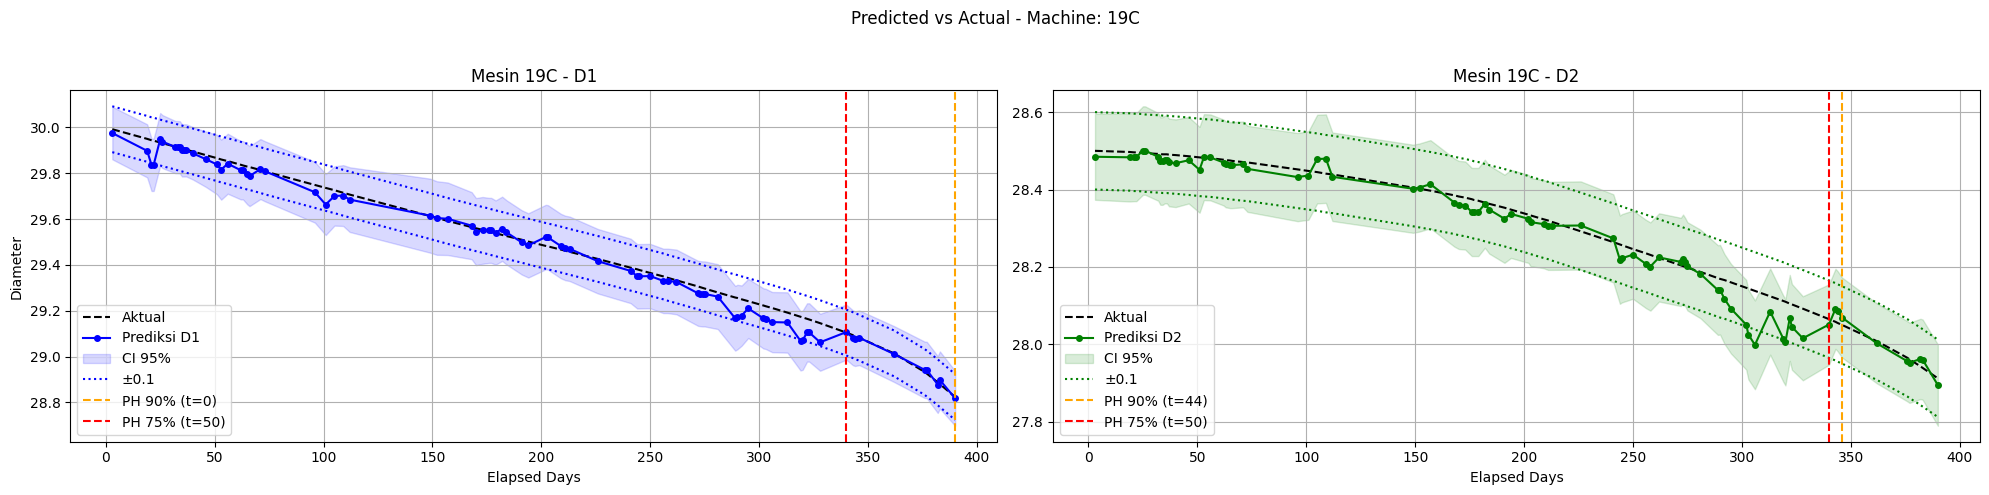

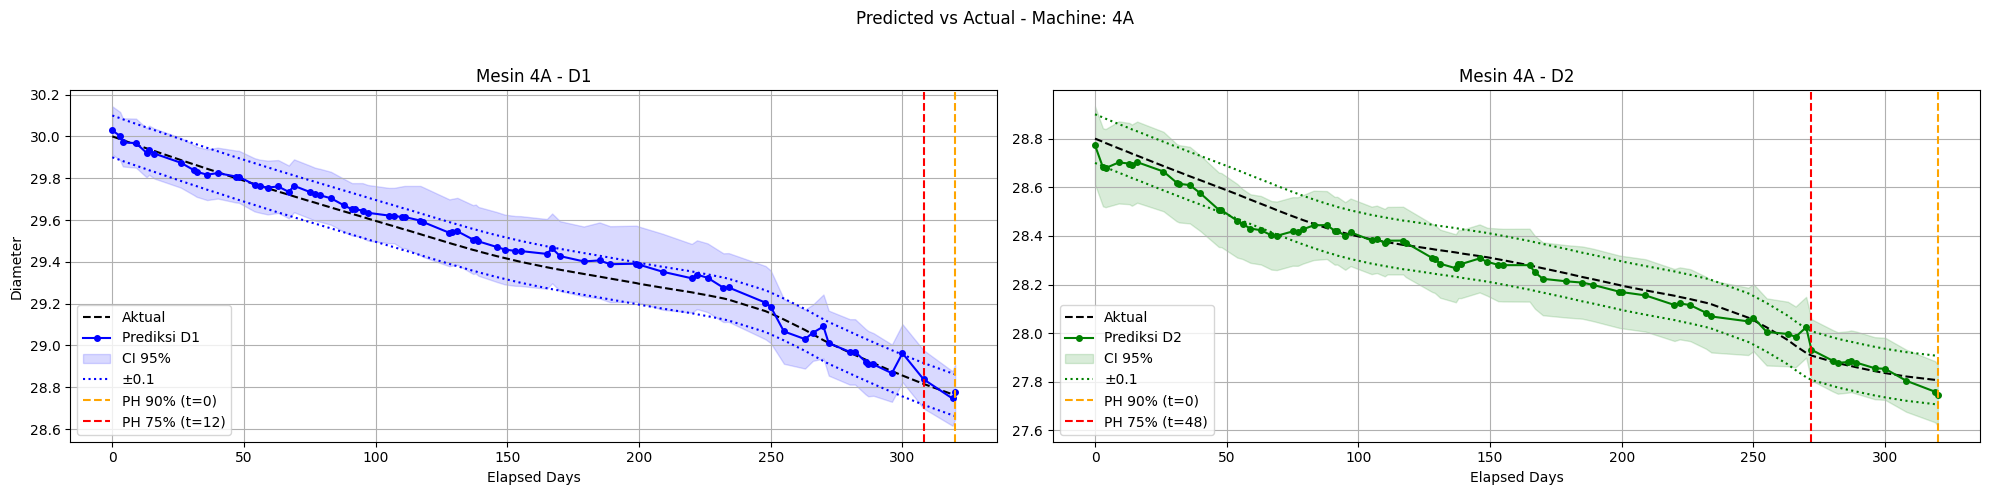

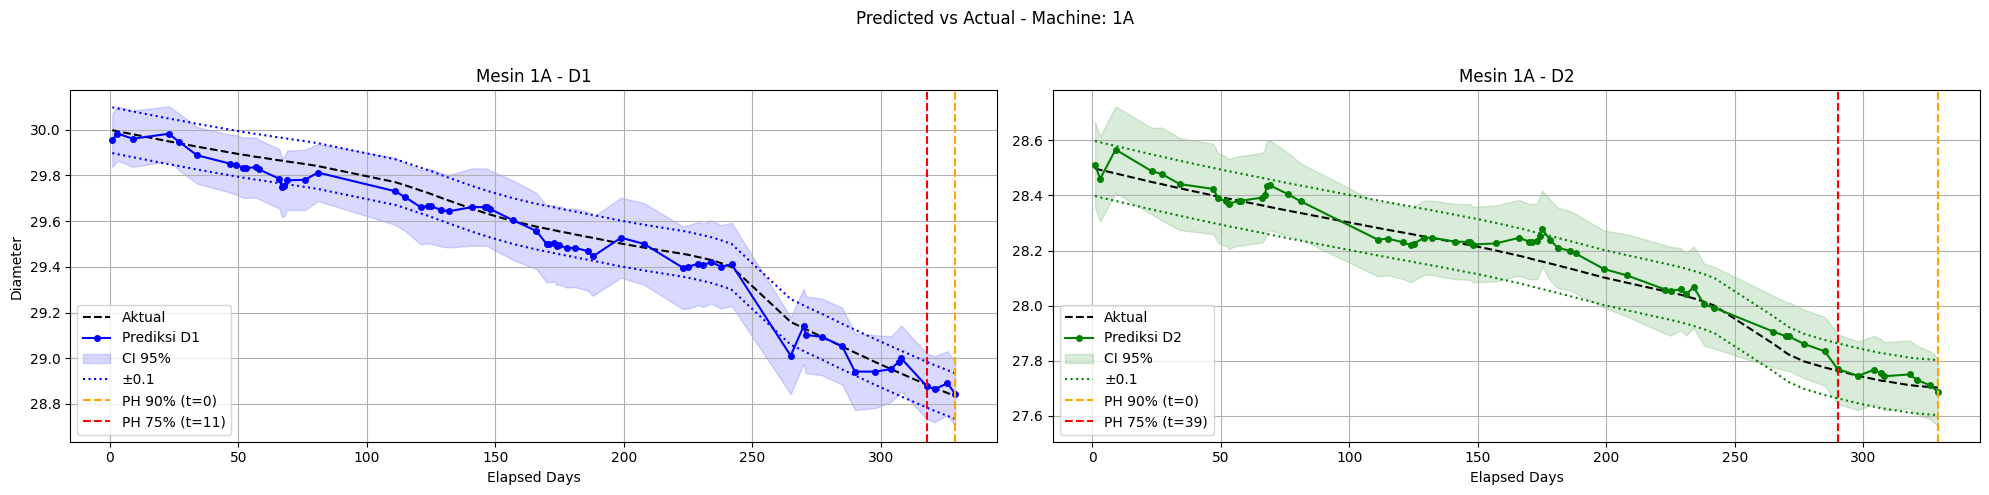

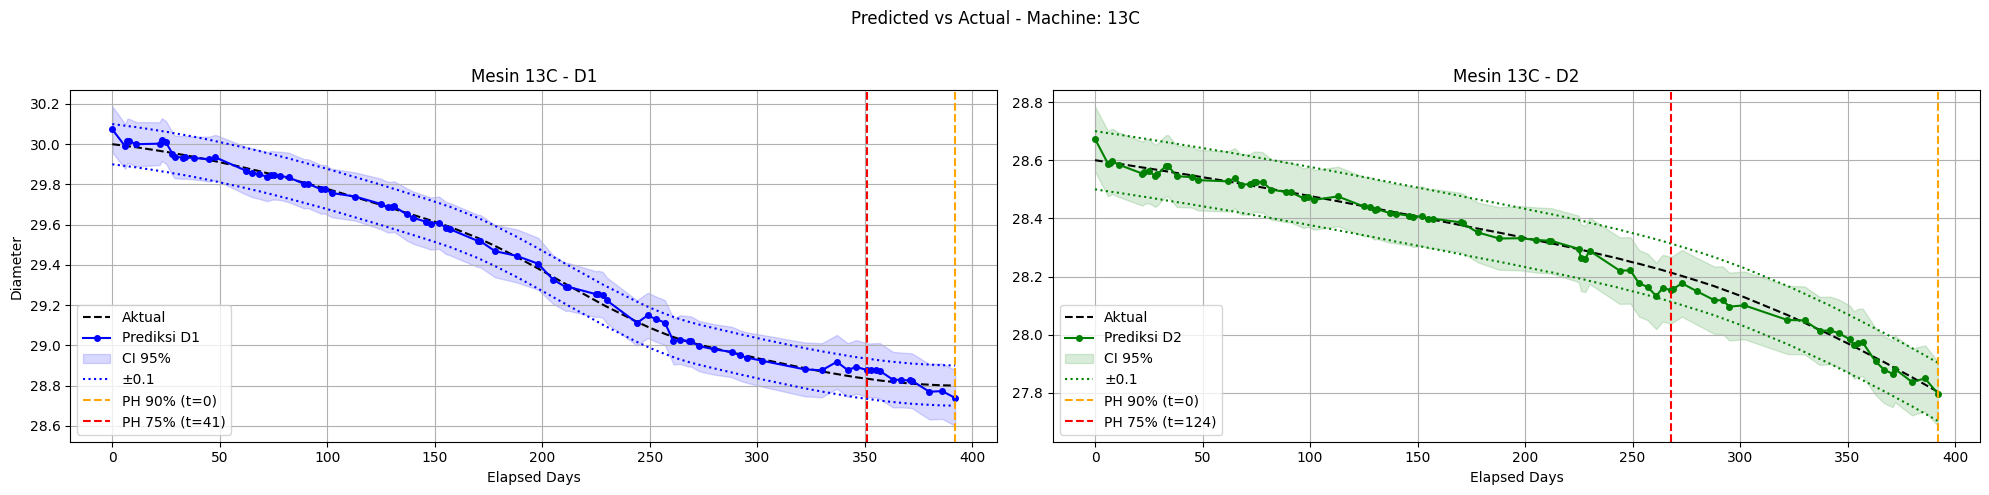

In [83]:
prognostic_horizon_df = pd.DataFrame()

for val_unit in validation_units:
    # Subset berdasarkan mesin
    val_unit_df = X_test_raw[X_test_raw['RSF'] == val_unit]
    elapsed = val_unit_df['elapsed_days'].values
    sort_idx = np.argsort(elapsed)

    X_val_sorted = val_unit_df[features].values[sort_idx]
    elapsed_sorted = elapsed[sort_idx]

    # Nilai aktual
    y_true_d1 = y_test.loc[val_unit_df.index, 'D1'].values[sort_idx]
    y_true_d2 = y_test.loc[val_unit_df.index, 'D2'].values[sort_idx]

    # Prediksi dan distribusi
    predicted_d1 = best_ngb_d1.predict(X_val_sorted)
    predicted_dist_d1 = best_ngb_d1.pred_dist(X_val_sorted)
    predicted_d2 = best_ngb_d2.predict(X_val_sorted)
    predicted_dist_d2 = best_ngb_d2.pred_dist(X_val_sorted)

    # Confidence interval (95%)
    ci_upper_d1 = predicted_dist_d1.dist.ppf(0.975)
    ci_lower_d1 = predicted_dist_d1.dist.ppf(0.025)
    ci_upper_d2 = predicted_dist_d2.dist.ppf(0.975)
    ci_lower_d2 = predicted_dist_d2.dist.ppf(0.025)

    # Hitung PH
    alpha = 0.1
    beta1 = 0.9
    beta2 = 0.75

    ph_1_d1, _ = prognostic_horizon(predicted_dist_d1, y_true_d1, elapsed_sorted, beta=beta1, alpha=alpha)
    ph_2_d1, _ = prognostic_horizon(predicted_dist_d1, y_true_d1, elapsed_sorted, beta=beta2, alpha=alpha)

    ph_1_d2, _ = prognostic_horizon(predicted_dist_d2, y_true_d2, elapsed_sorted, beta=beta1, alpha=alpha)
    ph_2_d2, _ = prognostic_horizon(predicted_dist_d2, y_true_d2, elapsed_sorted, beta=beta2, alpha=alpha)

    prognostic_horizon_df = pd.concat([prognostic_horizon_df, pd.DataFrame([
        {'mesin': val_unit, 'target': 'D1', 'prognostic_horizon': ph_1_d1, 'probability': beta1, 'alpha': alpha},
        {'mesin': val_unit, 'target': 'D1', 'prognostic_horizon': ph_2_d1, 'probability': beta2, 'alpha': alpha},
        {'mesin': val_unit, 'target': 'D2', 'prognostic_horizon': ph_1_d2, 'probability': beta1, 'alpha': alpha},
        {'mesin': val_unit, 'target': 'D2', 'prognostic_horizon': ph_2_d2, 'probability': beta2, 'alpha': alpha},
    ])], ignore_index=True)

    max_day = elapsed_sorted.max()
    t_ph_1_d1 = max_day - ph_1_d1 if ph_1_d1 is not None else 0
    t_ph_2_d1 = max_day - ph_2_d1 if ph_2_d1 is not None else 0
    t_ph_1_d2 = max_day - ph_1_d2 if ph_1_d2 is not None else 0
    t_ph_2_d2 = max_day - ph_2_d2 if ph_2_d2 is not None else 0

    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].plot(elapsed_sorted, y_true_d1, '--', color='black', label='Aktual')
    axes[0].plot(elapsed_sorted, predicted_d1, '-o', color='blue', label='Prediksi D1', markersize=4)
    axes[0].fill_between(elapsed_sorted, ci_lower_d1, ci_upper_d1, color='blue', alpha=0.15, label='CI 95%')
    axes[0].plot(elapsed_sorted, y_true_d1 + alpha, ':', color='blue', label=f'±{alpha}')
    axes[0].plot(elapsed_sorted, y_true_d1 - alpha, ':', color='blue')

    if t_ph_1_d1 is not None:
        axes[0].axvline(x=t_ph_1_d1, color='orange', linestyle='--',
                        label=f'PH {beta1*100:.0f}% (t={ph_1_d1})')
    if t_ph_2_d1 is not None:
        axes[0].axvline(x=t_ph_2_d1, color='red', linestyle='--',
                        label=f'PH {beta2*100:.0f}% (t={ph_2_d1})')

    axes[0].set_title(f'Mesin {val_unit} - D1')
    axes[0].set_xlabel('Elapsed Days')
    axes[0].set_ylabel('Diameter')
    axes[0].grid()
    axes[0].legend()

    axes[1].plot(elapsed_sorted, y_true_d2, '--', color='black', label='Aktual')
    axes[1].plot(elapsed_sorted, predicted_d2, '-o', color='green', label='Prediksi D2', markersize=4)
    axes[1].fill_between(elapsed_sorted, ci_lower_d2, ci_upper_d2, color='green', alpha=0.15, label='CI 95%')
    axes[1].plot(elapsed_sorted, y_true_d2 + alpha, ':', color='green', label=f'±{alpha}')
    axes[1].plot(elapsed_sorted, y_true_d2 - alpha, ':', color='green')
        
    if t_ph_1_d2 is not None:
        axes[1].axvline(x=t_ph_1_d2, color='orange', linestyle='--',
                        label=f'PH {beta1*100:.0f}% (t={ph_1_d2})')
    if t_ph_2_d2 is not None:
        axes[1].axvline(x=t_ph_2_d2, color='red', linestyle='--',
                        label=f'PH {beta2*100:.0f}% (t={ph_2_d2})')

    axes[1].set_title(f'Mesin {val_unit} - D2')
    axes[1].set_xlabel('Elapsed Days')
    axes[1].grid()
    axes[1].legend()

    plt.suptitle(f'Predicted vs Actual - Machine: {val_unit}')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [84]:
prognostic_horizon_df

,mesin,target,prognostic_horizon,probability,alpha
0,19C,D1,0,0.90,0.1
1,19C,D1,50,0.75,0.1
2,19C,D2,44,0.90,0.1
3,19C,D2,50,0.75,0.1
4,4A,D1,0,0.90,0.1
5,4A,D1,12,0.75,0.1
6,4A,D2,0,0.90,0.1
7,4A,D2,48,0.75,0.1
8,1A,D1,0,0.90,0.1
9,1A,D1,11,0.75,0.1


In [85]:
prognostic_horizon_df.groupby('probability')['prognostic_horizon'].mean().round().astype(int)

probability
0.75    47
0.90     6
Name: prognostic_horizon, dtype: int64

Diperoleh hasil rata-rata PH dari :
- Probabilitas 75% yaitu pada **47 hari menjelang EoL**
- Probabilitas 90% yaitu pada **6 hari menjelang EoL**
- Toleransi kesalahan diameter roller (D1 dan D2) adalah +- 0,1 mm.

### Alpha-Lambda Accuracy (α–λ)

Alpha-Lambda mengukur konsistensi dari prediksi model selama horizon sisa waktu dari waktu PH hingga waktu akhir (Saxena et al, 2010).
- Alpha (α) merupakan toleransi kesalahan absolut antara prediksi dan nilai aktual (dalam model ini menggunakan toleransi ±0.1 mm).
- Lambda (λ) merupakan fraksi waktu setelah PH di mana prediksi harus konsisten dalam ±α.

In [86]:
def alpha_lambda_accuracy(pred_dists, true_values, elapsed_days, time_frac=[0.5, 0.75, 0.9], beta=0.75, alpha=0.1):
    """
    Menghitung Alpha-Lambda Accuracy untuk prediksi degradasi (misalnya D1/D2).
    
    Parameters
    ----------
    pred_dists : list of NGBoost distributions
        Distribusi prediksi dari NGBoost.
    true_values : np.array
        Nilai aktual (target D1/D2).
    time_frac : list of float
        Fraksi waktu (dalam % dari total data) yang ingin dievaluasi.
    beta : float
        Probabilitas minimum (threshold).
    alpha : float
        Margin toleransi (± dari nilai aktual).
    
    Returns
    -------
    alpha_lambda : np.array
        Array biner (1 jika prediksi akurat di titik waktu tersebut, 0 jika tidak).
    probas : np.array
        Probabilitas prediksi berada dalam batas toleransi.
    """
    max_day = np.max(elapsed_days)
    remaining_frac = 1 - (elapsed_days / max_day)

    alpha_lambda = np.full(len(time_frac), -1)
    probas = np.full(len(time_frac), -1.0)

    for i, frac in enumerate(time_frac):
        # Cari indeks di mana fraksi remaining time paling mendekati 'frac'
        idx = np.argmin(np.abs(remaining_frac - frac))

        true_val = true_values[idx]
        lower = true_val - alpha
        upper = true_val + alpha

        dist = pred_dists[idx]
        prob = dist.cdf(upper) - dist.cdf(lower)

        probas[i] = prob
        alpha_lambda[i] = 1 if prob >= beta else 0

    return alpha_lambda, probas

In [87]:
alpha_lambda_results = pd.DataFrame()

time_frac_list = [0.5, 0.75, 0.9, 0.95]
beta_list = [0.75]
alpha = 0.1

for val_unit in validation_units:
    val_unit_df = X_test_raw[X_test_raw['RSF'] == val_unit]
    elapsed = val_unit_df['elapsed_days'].values
    sort_idx = np.argsort(elapsed)

    X_val_sorted = val_unit_df[features].values[sort_idx]
    elapsed_sorted = elapsed[sort_idx]

    y_true_d1 = y_test.loc[val_unit_df.index, 'D1'].values[sort_idx]
    pred_dists_d1 = best_ngb_d1.pred_dist(X_val_sorted)

    for beta in beta_list:
        alpha_lambda_d1, probs_d1 = alpha_lambda_accuracy(
            pred_dists=pred_dists_d1,
            true_values=y_true_d1,
            elapsed_days=elapsed_sorted,
            time_frac=time_frac_list,
            beta=beta,
            alpha=alpha
        )

        for i, frac in enumerate(time_frac_list):
            alpha_lambda_results = pd.concat([alpha_lambda_results, pd.DataFrame([{
                'mesin': val_unit,
                'target': 'D1',
                'time_fraction': frac,
                'alpha_lambda': alpha_lambda_d1[i],
                'probability': probs_d1[i],
                'alpha': alpha,
                'beta': beta
            }])], ignore_index=True)

    y_true_d2 = y_test.loc[val_unit_df.index, 'D2'].values[sort_idx]
    pred_dists_d2 = best_ngb_d2.pred_dist(X_val_sorted)

    for beta in beta_list:
        alpha_lambda_d2, probs_d2 = alpha_lambda_accuracy(
            pred_dists=pred_dists_d2,
            true_values=y_true_d2,
            elapsed_days=elapsed_sorted,
            time_frac=time_frac_list,
            beta=beta,
            alpha=alpha
        )

        for i, frac in enumerate(time_frac_list):
            alpha_lambda_results = pd.concat([alpha_lambda_results, pd.DataFrame([{
                'mesin': val_unit,
                'target': 'D2',
                'time_fraction': frac,
                'alpha_lambda': alpha_lambda_d2[i],
                'probability': probs_d2[i],
                'alpha': alpha,
                'beta': beta
            }])], ignore_index=True)

In [88]:
alpha_lambda_results.groupby('time_fraction')['alpha_lambda'].mean()

time_fraction
0.50    0.625
0.75    1.000
0.90    0.875
0.95    0.750
Name: alpha_lambda, dtype: float64

In [89]:
alpha_lambda_results.groupby('time_fraction')['probability'].mean()

time_fraction
0.50    0.800970
0.75    0.842360
0.90    0.850626
0.95    0.835100
Name: probability, dtype: float64

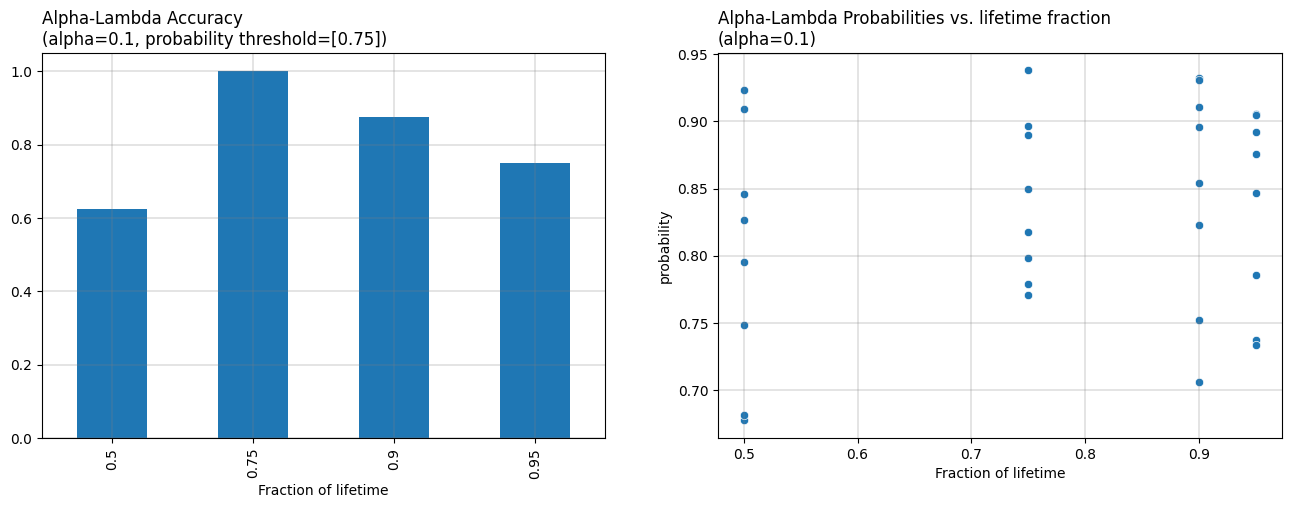

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

alpha_lambda_results.groupby('time_fraction')['alpha_lambda'].mean().plot.bar(ax=ax[0])
ax[0].grid(color='grey', linewidth=0.3)
ax[0].set_title(f'Alpha-Lambda Accuracy \n(alpha={alpha}, probability threshold={beta_list})', loc='left')
ax[0].set_xlabel('Fraction of lifetime')


sns.scatterplot(data=alpha_lambda_results, x='time_fraction', y='probability', ax=ax[1])
ax[1].set_title(f'Alpha-Lambda Probabilities vs. lifetime fraction\n(alpha={alpha})', loc='left')
ax[1].grid(color='grey', linewidth=0.3)
ax[1].set_xlabel('Fraction of lifetime')

fig.show()

- Prediksi di tengah masa hidup komponen cenderung lebih stabil dan akurat.
- Pada awal waktu (λ = 0.5), informasi degradasi belum cukup kuat, sehingga prediksi lebih tidak pasti.
- Di akhir masa hidup (λ = 0.95), prediksi bisa lebih fluktuatif karena keausan ekstrem atau noise akhir siklus.
- Secara keseluruhan, model cukup stabil dan reliabel di sepanjang umur roller.
- Terlihat sebaran probabilitas tidak selalu tinggi meskipun akurasi bagus.

### Relative Accuracy (RA)

Relative Accuracy mengukur seberapa dekat rata-rata prediksi terhadap nilai aktual relatif terhadap panjang waktu. RA merupakan indikator tingkat akurasi kumulatif model selama periode setelah PH (Saxena et al, 2010).

In [91]:
def relative_accuracy(pred_mean, y_true):
    """
    Relative Accuracy = 1 - |pred - actual| / actual
    """
    y_true = np.array(y_true)
    pred_mean = np.array(pred_mean)
    eps = 1e-6  # untuk menghindari pembagian nol
    ra = 1 - (np.abs(pred_mean - y_true) / (y_true + eps))
    return ra

In [92]:
relative_acc_df = pd.DataFrame()

for val_unit in validation_units:
    val_unit_df = X_test_raw[X_test_raw['RSF'] == val_unit]
    elapsed = val_unit_df['elapsed_days'].values
    sort_idx = np.argsort(elapsed)
    X_sorted = val_unit_df[features].values[sort_idx]

    elapsed_sorted = elapsed[sort_idx]

    y_true_d1 = y_test.loc[val_unit_df.index, 'D1'].values[sort_idx]
    pred_d1 = best_ngb_d1.predict(X_sorted)
    ra_d1 = relative_accuracy(pred_d1, y_true_d1)

    y_true_d2 = y_test.loc[val_unit_df.index, 'D2'].values[sort_idx]
    pred_d2 = best_ngb_d2.predict(X_sorted)
    ra_d2 = relative_accuracy(pred_d2, y_true_d2)

    remaining_frac = 1 - (elapsed_sorted / elapsed_sorted.max())

    for tf in time_frac_list:
        t_index = np.argmin(np.abs(remaining_frac - tf))  # cari yang paling mendekati fraksi waktu sisa


        relative_acc_df = pd.concat([relative_acc_df, pd.DataFrame([
            {
                'mesin': val_unit,
                'target': 'D1',
                'time_fraction': tf,
                'relative_accuracy': ra_d1[t_index],
            },
            {
                'mesin': val_unit,
                'target': 'D2',
                'time_fraction': tf,
                'relative_accuracy': ra_d2[t_index],
            }
        ])], ignore_index=True)

In [93]:
relative_acc_df.groupby('time_fraction')['relative_accuracy'].mean()

time_fraction
0.50    0.999084
0.75    0.999031
0.90    0.999236
0.95    0.999002
Name: relative_accuracy, dtype: float64

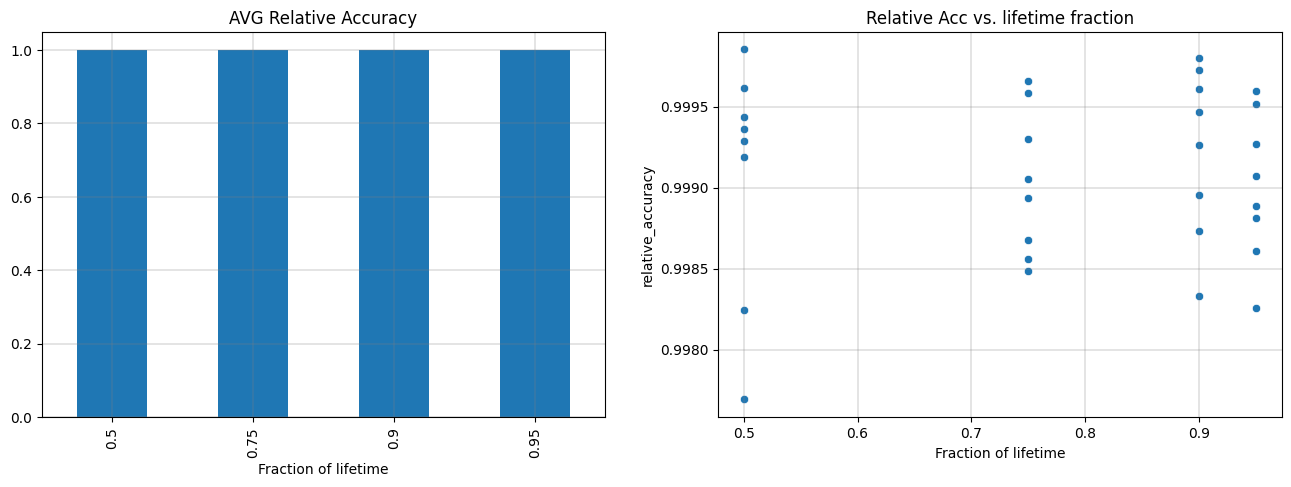

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

relative_acc_df.groupby('time_fraction')['relative_accuracy'].mean().plot.bar(ax=ax[0])
ax[0].grid(color='grey', linewidth=0.3)
ax[0].set_title('AVG Relative Accuracy')
ax[0].set_xlabel('Fraction of lifetime')

sns.scatterplot(data=relative_acc_df, x='time_fraction', y='relative_accuracy', ax=ax[1])
ax[1].set_title('Relative Acc vs. lifetime fraction')
ax[1].grid(color='grey', linewidth=0.3)
ax[1].set_xlabel('Fraction of lifetime')

fig.show()

- Model prediksi diameter roller kamu memiliki akurasi yang sangat tinggi dan stabil sepanjang siklus umur.

- Performa ini sangat mendukung aplikasi prediktif maintenance karena model dapat diandalkan untuk estimasi kondisi roller kapan saja.

- Penurunan RA kecil di akhir tetap dalam batas wajar dan tidak signifikan secara praktis.

### Convergence (opsional)

Convergence digunakan untuk mengukur apakah prediksi mendekati nilai aktual saat hampir mencapai akhir masa pakai (Saxena et al, 2010). Prediksi diharapkan makin stabil dan dekat dengan aktual seiring waktu.

Convergence sering dilihat sebagai indikator akhir yang memastikan bahwa model tetap reliable saat digunakan untuk perencanaan pemeliharaan (maintenance scheduling), terutama menjelang kerusakan. Jika convergence buruk, maka meskipun metrik lain seperti MAE atau R² baik, model tetap tidak aman dipakai di lapangan karena gagal mendeteksi kondisi kritis.

In [95]:
def convergence_score(pred_mean, y_true, elapsed_days, threshold_frac=0.8):
    """
    Hitung skor convergence berdasarkan Relative Accuracy dari titik threshold RUL ke akhir.

    Parameters
    ----------
    pred_mean : np.array
        Prediksi model
    y_true : np.array
        Nilai aktual
    elapsed_days : np.array
        Waktu aktual (harus urut dari awal ke akhir)
    threshold_frac : float
        Fraksi waktu (dari total lifetime) untuk mulai menghitung convergence

    Returns
    -------
    convergence : float
        Rata-rata Relative Accuracy dari threshold hingga akhir waktu
    """
    assert len(pred_mean) == len(y_true) == len(elapsed_days), "Semua array harus sama panjang"

    max_day = elapsed_days.max()
    threshold_time = threshold_frac * max_day
    start_idx = np.argmax(elapsed_days >= threshold_time)

    eps = 1e-6
    ra_tail = 1 - (np.abs(pred_mean[start_idx:] - y_true[start_idx:]) / (y_true[start_idx:] + eps))

    return np.mean(ra_tail)

In [96]:
convergence_df = pd.DataFrame()

for val_unit in validation_units:
    val_unit_df = X_test_raw[X_test_raw['RSF'] == val_unit]
    elapsed = val_unit_df['elapsed_days'].values
    sort_idx = np.argsort(elapsed)
    X_sorted = val_unit_df[features].values[sort_idx]
    elapsed_sorted = elapsed[sort_idx]

    # D1
    y_true_d1 = y_test.loc[val_unit_df.index, 'D1'].values[sort_idx]
    pred_mean_d1 = best_ngb_d1.predict(X_sorted)
    conv_d1 = convergence_score(pred_mean_d1, y_true_d1, elapsed_sorted, threshold_frac=0.8)

    convergence_df = pd.concat([convergence_df, pd.DataFrame([{
        'mesin': val_unit,
        'target': 'D1',
        'convergence_score': conv_d1
    }])], ignore_index=True)

    # D2
    y_true_d2 = y_test.loc[val_unit_df.index, 'D2'].values[sort_idx]
    pred_mean_d2 = best_ngb_d2.predict(X_sorted)
    conv_d2 = convergence_score(pred_mean_d2, y_true_d2, elapsed_sorted, threshold_frac=0.8)

    convergence_df = pd.concat([convergence_df, pd.DataFrame([{
        'mesin': val_unit,
        'target': 'D2',
        'convergence_score': conv_d2
    }])], ignore_index=True)


In [97]:
convergence_df

,mesin,target,convergence_score
0,19C,D1,0.998856
1,19C,D2,0.998682
2,4A,D1,0.999163
3,4A,D2,0.998956
4,1A,D1,0.998804
5,1A,D2,0.998823
6,13C,D1,0.998883
7,13C,D2,0.999444


In [98]:
convergence_df.groupby('target')['convergence_score'].mean()

target
D1    0.998926
D2    0.998976
Name: convergence_score, dtype: float64

Hasil untuk semua validation_units menunjukkan nilai rata-rata untuk D1 dan D2 di mendekati 1.
- Menunjukkan prediksi yang stabil dan akurat menjelang akhir masa hidup komponen.
- Berarti model NGBoost kamu mampu menangkap pola degradasi dengan baik, bahkan menjelang fase kritis.
